In [1]:
import os
import getpass

os.environ["TAVILY_API_KEY"] = getpass.getpass()

In [2]:
import json
from langchain.tools import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.chat import MessagesPlaceholder

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

def create_agent(llm, tools, system_message: str):
    functions = [format_tool_to_openai_function(t) for t in tools]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([t.name for t in tools]))
    return prompt | llm.bind_functions(functions)

In [3]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [4]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [5]:
import functools

def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"Result: {result}")
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type","name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4-1106-preview")

research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)

chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

/home/vscode/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [6]:
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)

def tool_node(state):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    last_message = messages[-1]
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(tool=tool_name, tool_input=tool_input)
    response = tool_executor.invoke(action)
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    return {"messages": [function_message]}

In [7]:
def router(state):
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "end"
    return "continue"

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

Result: content='' additional_kwargs={'function_call': {'arguments': '{"query":"UK population by year for the past 5 years"}', 'name': 'tavily_search_results_json'}}
{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"UK population by year for the past 5 years"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
------
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://www.macrotrends.net/countries/GBR/united-kingdom/population\', \'content\': \'The current population of U.K. in 2024 is 67,961,439, a 0.33% increase from 2023. The population of U.K. in 2023 was 67,736,802, a 0.34% increase from 2022. The population of U.K. in 2022 was 67,508,936, a 0.34% increase from 2021. The population of U.K. in 2021 was 67,281,039, a 0.33% increase from 2020. Download Historical Data Save as Image\'}, {\'url\': \'https://www.gov.uk/governmen

Python REPL can execute arbitrary code. Use with caution.


Result: content='' additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# UK population data for the past 5 years\\nyears = [2020, 2021, 2022, 2023, 2024]\\npopulation = [67054557, 67281039, 67508936, 67736802, 67961439]\\n\\n# Create line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, population, marker=\'o\')\\nplt.title(\'UK Population Growth Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'Population\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.tight_layout()\\nplt.show()"}', 'name': 'python_repl'}}
{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# UK population data for the past 5 years\\nyears = [2020, 2021, 2022, 2023, 2024]\\npopulation = [67054557, 67281039, 67508936, 67736802, 67961439]\\n\\n# Create line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, population, marker=\'o\')\\nplt.title(\'UK Popu

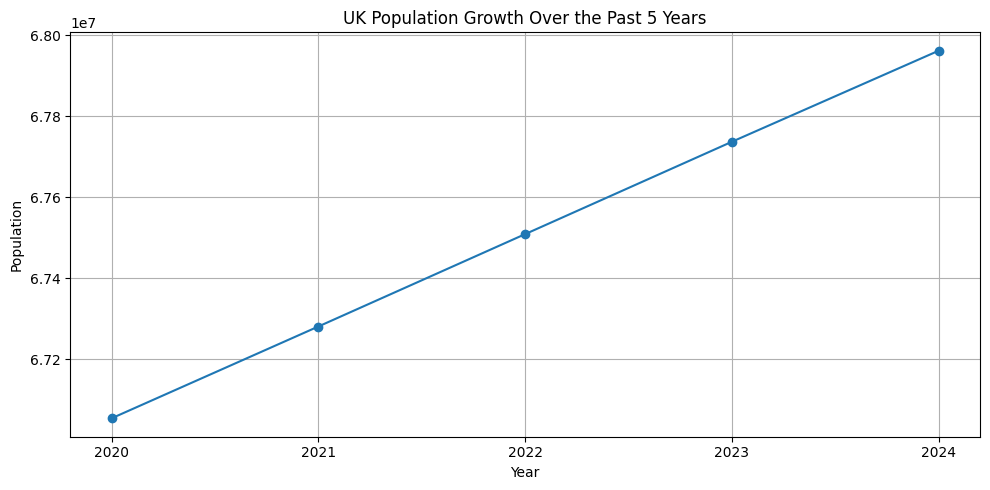

{'call_tool': {'messages': [FunctionMessage(content="python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# UK population data for the past 5 years\nyears = [2020, 2021, 2022, 2023, 2024]\npopulation = [67054557, 67281039, 67508936, 67736802, 67961439]\n\n# Create line graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, population, marker='o')\nplt.title('UK Population Growth Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('Population')\nplt.grid(True)\nplt.xticks(years)\nplt.tight_layout()\nplt.show()\n```\nStdout: ", name='python_repl')]}}
------
Result: content=''
{'Chart Generator': {'messages': [HumanMessage(content='', name='Chart Generator')], 'sender': 'Chart Generator'}}
------
Result: content="The code for the line graph has been successfully executed in the Python REPL environment, plotting the UK population growth over the past 5 years. However, since I'm unable to display images, you will not be able to view the graph here.\n\n

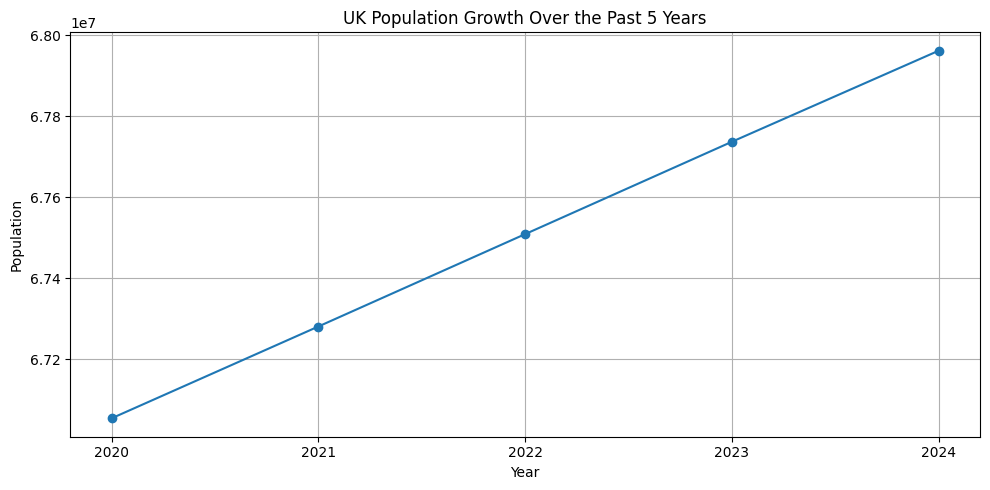

Result: content='' additional_kwargs={'function_call': {'arguments': '{\n    "code": "import matplotlib.pyplot as plt\\n\\n# UK population data for the past 5 years\\nyears = [2020, 2021, 2022, 2023, 2024]\\npopulation = [67054557, 67281039, 67508936, 67736802, 67961439]\\n\\n# Create line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, population, marker=\'o\')\\nplt.title(\'UK Population Growth Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'Population\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.tight_layout()\\nplt.show()"\n}', 'name': 'python_repl'}}
{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n    "code": "import matplotlib.pyplot as plt\\n\\n# UK population data for the past 5 years\\nyears = [2020, 2021, 2022, 2023, 2024]\\npopulation = [67054557, 67281039, 67508936, 67736802, 67961439]\\n\\n# Create line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, population, marker=\'o\')\\nplt

KeyboardInterrupt: 

In [10]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's population growth over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    {"recursion_limit":150}
):
    print(s)
    print("------")